In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import random

# 1次元GMM

[]

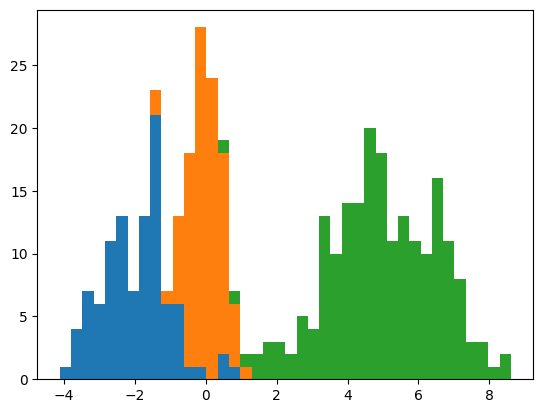

In [2]:
mean = [-2., 0., 5.]
var = [1., 0.5, 1.5]
samples = [100, 100, 200]

rng = np.random.default_rng()
d0 = pd.DataFrame({'data':rng.normal(mean[0], var[0], samples[0])})
d1 = pd.DataFrame({'data':rng.normal(mean[1], var[1], samples[1])})
d2 = pd.DataFrame({'data':rng.normal(mean[2], var[2], samples[2])})
d0['label'] = 0
d1['label'] = 1
d2['label'] = 2

X = pd.concat([d0['data'], d1['data'], d2['data']], ignore_index=True)
Y = pd.concat([d0['label'], d1['label'], d2['label']], ignore_index=True)
plt.hist([X[Y==0], X[Y==1], X[Y==2]], stacked=True, bins=40 ,label=Y)
plt.plot()

In [3]:
# parameters
K = 3
T = 100
EPSILON = 0.01

In [4]:
def gaussian_value(x, mu, sigma):
    return np.exp(-(x-mu)**2 / (2.*sigma)) / np.sqrt(2.*np.pi*sigma)

In [5]:
def initialize(x):
    return random.sample(list(x), K)

In [6]:
def E_step(x, mu, sigma, mix_co):
    gamma = []
    for n in range(len(list(x))):
        densities = []
        for k in range(K):
            gamma_nk = mix_co[k] * gaussian_value(x[n], mu[k], sigma[k])
            densities.append(gamma_nk)
        gamma_nk = densities / np.sum(densities)
        gamma.append(gamma_nk)
    gamma = pd.DataFrame(gamma) # データごとの負担率(NxK)
    return gamma

In [7]:
def M_step(x, mu, gamma):
    N_k = gamma.sum()
    weighted_sum = [0]*K # クラスターごとのx_nの重みつき平均
    weighted_var = [0]*K # クラスターごとの分散共分散の重みつき平均
    for k in range(K):
        for n in range(len(list(x))):
            weighted_sum[k] += gamma.loc[n,k] * x[n]
            weighted_var[k] += gamma.loc[n,k] * (x[n] - mu[k])**2

    mu_new = []
    sigma = []
    mix_co = list(np.array(N_k) / len(list(x)))
    for k in range(K):
        mu_new.append(weighted_sum[k] / N_k[k])
        sigma.append(weighted_var[k] / N_k[k])
    return mu_new, sigma, mix_co

In [8]:
def EM(x):
    mu = initialize(x)
    print(f"initial mean:{mu}")
    sigma = [3]*3
    mix_co = [0.33]*3
    likelihood = -np.inf
    for t in range(T):
        gamma = E_step(x, mu, sigma, mix_co)
        mu_new, sigma_new, mix_co_new = M_step(x, mu, gamma)
        # 収束確認
        likelihood_new = 0
        for n in range(len(list(x))):
            for k in range(K):
                likelihood_new += gamma.loc[n,k] * np.log(mix_co_new[k] * gaussian_value(x[n], mu_new[k], sigma_new[k]))
        if (t%5==0):
            print(f"t={t} -> likelihood: {likelihood_new}")
        if (likelihood_new - likelihood < EPSILON):
            break
        mu = mu_new
        sigma = sigma_new
        mix_co = mix_co_new
        likelihood = likelihood_new

    print(f"cycle count: {t+1}")
    return mu, sigma

In [9]:
mu, sigma = EM(X)
print(f"estimated mean: {mu}")
print(f"estimated variance: {sigma}")

initial mean:[-0.49327473611850337, 4.6256985974787925, 6.212542119291406]
t=0 -> likelihood: -1123.688110275969
t=5 -> likelihood: -1091.1958513963314
t=10 -> likelihood: -1089.0346221464918
t=15 -> likelihood: -1086.4578216852249
t=20 -> likelihood: -1082.7870937781936
t=25 -> likelihood: -1077.1519464536775
t=30 -> likelihood: -1068.0670154524043
t=35 -> likelihood: -1053.687638175244
t=40 -> likelihood: -1035.8079798367273
t=45 -> likelihood: -1023.3834605055675
t=50 -> likelihood: -1018.5275119272544
t=55 -> likelihood: -1016.7775213688999
t=60 -> likelihood: -1015.887839286257
t=65 -> likelihood: -1015.2452513442429
t=70 -> likelihood: -1014.6995141473244
t=75 -> likelihood: -1014.2129408570604
t=80 -> likelihood: -1013.7745285405623
t=85 -> likelihood: -1013.3794426644832
t=90 -> likelihood: -1013.0241977065718
t=95 -> likelihood: -1012.705585843462
cycle count: 100
estimated mean: [-0.8427185244807218, 4.301431430959065, 6.412211968264069]
estimated variance: [1.852788561019936

# 2次元GMM

In [10]:
means = np.array([
    [0, 3],
    [-2, -1],
    [3, -2]
    ])
covs = np.array([
    [[1, -0.4], [-0.4, 1]],
    [[1.5, 0.3], [0.3, 1.5]],
    [[1, 0.5], [0.5, 0.6]]
    ])
sample_size = 200
K = 3 # クラスター数
D = 2 # 観測データの次元

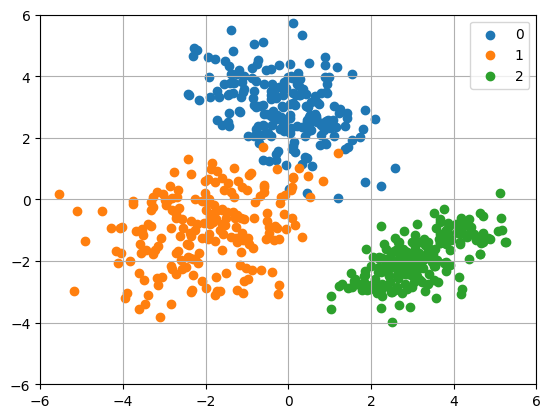

In [11]:
# numpy
# fig, ax = plt.subplots()
# data_np = np.zeros((1, 3))
# for i in range(K):
#     data_1 = np.random.multivariate_normal(means[i], covs[i], size=sample_size)
#     data_1 = np.concatenate((data_1, np.full((sample_size, 1), i)), axis=1)
#     data_np = np.concatenate((data_np, data_1))
#     ax.scatter(data_1[:,0], data_1[:,1], color=matplotlib.cm.tab10(i), label=i)
# plt.show()
# data_np = data_np[1:, :]

#scipy
fig, ax = plt.subplots()
data = np.zeros((1, 2))
cluster_label = np.zeros((1, 1), dtype=int)
for i in range(K):
    data_1 = multivariate_normal(means[i], covs[i]).rvs(size=sample_size)
    data = np.concatenate((data, data_1))
    cluster_label = np.concatenate((cluster_label, np.full((sample_size, 1), i)))
    ax.scatter(data_1[:,0], data_1[:,1], color=matplotlib.cm.tab10(i), label=i)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid()
plt.legend()
plt.show()
data = pd.DataFrame(data[1:, :]) # サンプル点の座標
cluster_label = pd.DataFrame(cluster_label[1:, :]) # サンプル点のクラスター番号

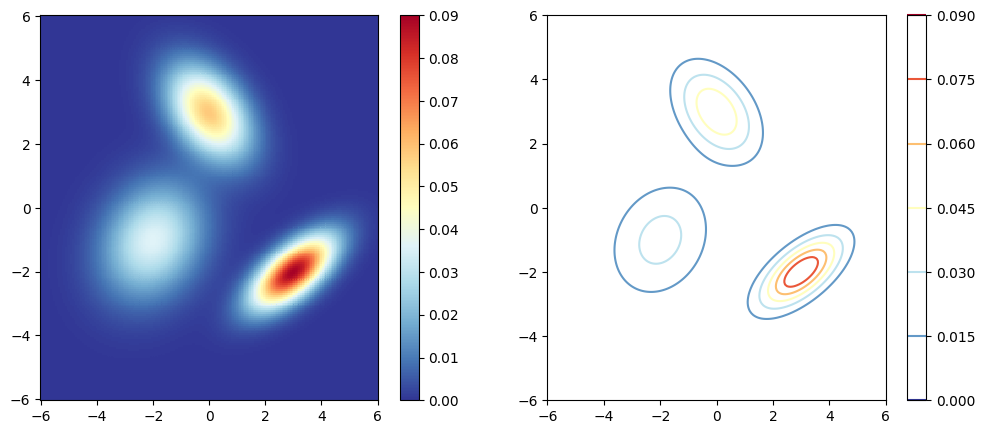

In [12]:
# 確率密度関数の可視化
posx, posy = np.mgrid[-6:6:200j, -6:6:200j]
pos = np.dstack((posx, posy))
z = 0
for k in range(K):
    z += multivariate_normal(means[k], covs[k]).pdf(pos) / K

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.pcolor(posx, posy, z, vmin=0., vmax=0.09, cmap="RdYlBu_r")
plt.colorbar()

plt.subplot(122)
plt.contour(posx, posy, z, cmap="RdYlBu_r")
plt.colorbar()
plt.show()

In [13]:
def gaussian_value(xn, mu, sigma):
    return multivariate_normal(mu, sigma).pdf(xn)

In [14]:
def initialize(x):
    idx = random.sample(range(0, len(x)), K)
    res = []
    for i in idx:
        res.append(x.loc[i, :])
    return np.array(res)

In [15]:
print(initialize(data))

[[-3.1686256  -2.53864995]
 [ 2.24979067  0.45358143]
 [ 1.02492242 -3.55083437]]


In [16]:
def E_step(x: pd.DataFrame, mu, sigma, mix_co):
    N = len(x)
    gamma = []
    for n in range(N):
        pdf = []
        for k in range(K):
            gamma_nk = mix_co[k] * gaussian_value(x.loc[n, :], mu[k], sigma[k])
            pdf.append(gamma_nk)
        gamma_nk = pdf / np.sum(pdf)
        gamma.append(gamma_nk)
    gamma = pd.DataFrame(gamma)
    return gamma

In [24]:
def M_step(x: pd.DataFrame, mu, gamma):
    N = len(x)
    N_k = np.array(gamma.sum())
    mu_new = np.array([0.]*(K*D)).reshape([K, D])
    sigma_new = np.array([0.]*(K*D*D)).reshape([K, D, D])
    mix_co = np.array(N_k) / N
    for k in range(K):
        for n in range(N):
            mu_new[k] += gamma.loc[n, k] * np.array(x.loc[n, :]) / N_k[k]
            x_std = (np.array(x.loc[n,:]) - np.array(mu[k])).reshape(-1, 1)
            sigma_new[k] += gamma.loc[n, k] * x_std @ x_std.T / N_k[k]
    return mu_new, sigma_new, mix_co

In [18]:
def EM(x):
    mu = initialize(x)
    print(f"initial mean:\n{mu}")
    sigma = np.array([[3., 0.1], [0.1, 3]]*K)
    mix_co = np.array([0.33]*K)
    likelihood = -np.inf
    for t in range(T):
        gamma = E_step(x, mu, sigma, mix_co)
        mu_new, sigma_new, mix_co_new = M_step(x, mu, gamma)

        # 収束確認
        likelihood_new = 0
        for n in range(len(x)):
            for k in range(K):
                likelihood_new += gamma.loc[n,k] * np.log(mix_co_new[k] * gaussian_value(x.loc[n,:], mu_new[k], sigma_new[k]))
        if (t%5==0):
            print(f"t={t} -> likelihood: {likelihood_new}")
        if (likelihood_new - likelihood < EPSILON):
            break

        mu = mu_new
        sigma = sigma_new
        mix_co = mix_co_new
        likelihood = likelihood_new

    print(f"cycle count: {t+1}")
    return mu, sigma, gamma

In [25]:
mu, sigma, gamma = EM(data)
print(f"estimated means:\n{mu}")
print(f"estimated covariances:\n{sigma}")

initial mean:
[[-2.71406909 -2.4286865 ]
 [ 2.28027626 -3.1355009 ]
 [ 0.45638548  1.34983077]]
t=0 -> likelihood: -2893.961696162901
t=5 -> likelihood: -2606.1242819283543
t=10 -> likelihood: -2426.074704333032
t=15 -> likelihood: -2311.0280789030917
cycle count: 20
estimated means:
[[-2.00618716 -0.96812416]
 [ 3.16168498 -1.92713055]
 [-0.0850559   2.94907276]]
estimated covariances:
[[[ 1.55495023  0.36636314]
  [ 0.36636314  1.3878378 ]]

 [[ 0.91728731  0.48428848]
  [ 0.48428848  0.58527223]]

 [[ 0.97166237 -0.40558389]
  [-0.40558389  1.12566412]]]


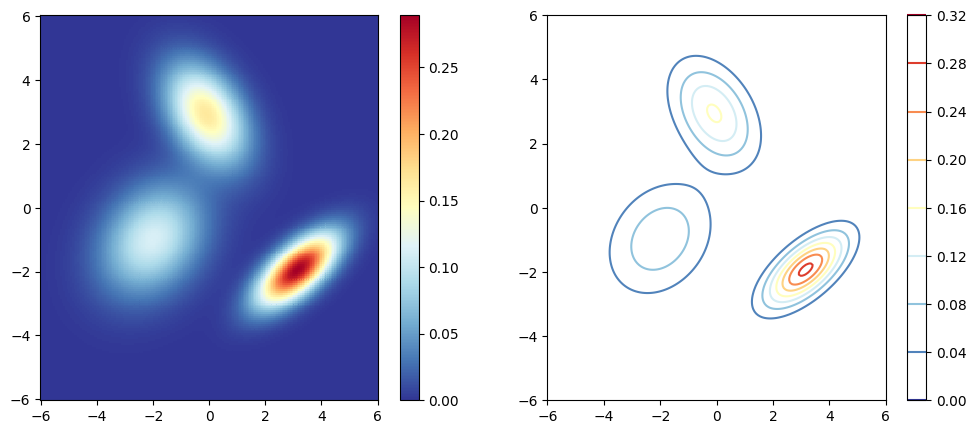

In [26]:
z = 0
for k in range(K):
    z += multivariate_normal(mu[k], sigma[k]).pdf(pos)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.pcolor(posx, posy, z, cmap="RdYlBu_r")
plt.colorbar()

plt.subplot(122)
plt.contour(posx, posy, z, cmap="RdYlBu_r")
plt.colorbar()
plt.show()

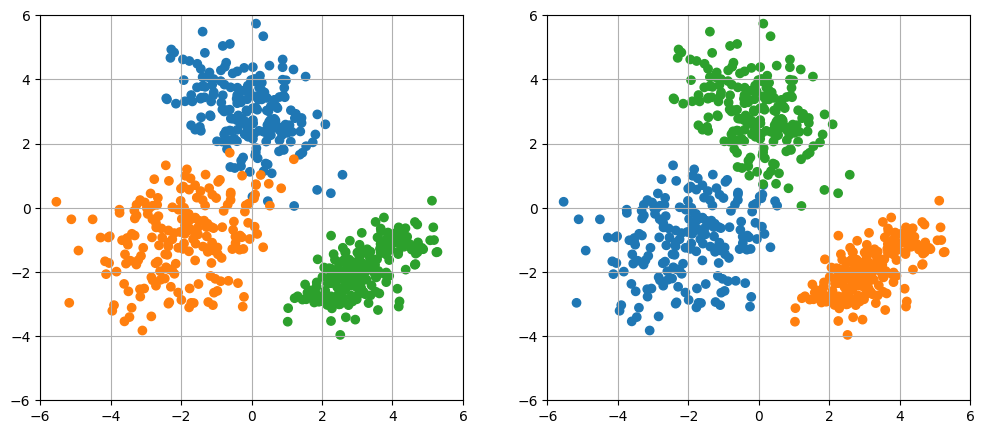

In [27]:
plt.figure(figsize=(12, 5))
# 正解ラベル
plt.subplot(121)
plt.scatter(data.loc[:,0], data.loc[:,1], color=matplotlib.cm.tab10(cluster_label.loc[:,0]))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid()

# 推定ラベル
plt.subplot(122)
estimated_label = gamma.idxmax(axis=1).values
plt.scatter(data.loc[:,0], data.loc[:,1], color=matplotlib.cm.tab10(estimated_label))
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid()
# plt.legend()
plt.show()